# Anomaliedetectie a.d.h.v. Numentas HTM algoritme op Gentse parkingdata

In [1]:
import time
import csv
import datetime
import os
import numpy as np
import random
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from htm.bindings.sdr import SDR, Metrics
from htm.encoders.rdse import RDSE, RDSE_Parameters
from htm.encoders.date import DateEncoder
from htm.bindings.algorithms import SpatialPooler
from htm.bindings.algorithms import TemporalMemory
from htm.algorithms.anomaly_likelihood import AnomalyLikelihood
from htm.bindings.algorithms import Predictor

### HTM is een recurrent neuraal netwerk, hierbij moeten vooraf parameters ingesteld worden

In [2]:
parameters = {
 'enc': {
      "value" :
         {'resolution': 0.88, 'size': 700, 'sparsity': 0.02},
      "time": 
         {'timeOfDay': (30, 1), 'weekend': 21, 'dayOfWeek': (14, 2)}
 },
 'predictor': {'sdrc_alpha': 0.1},
 'sp': {'boostStrength': 3.0,
        'columnCount': 1638,
        'localAreaDensity': 0.04395604395604396,
        'potentialPct': 0.85,
        'synPermActiveInc': 0.04,
        'synPermConnected': 0.13999999999999999,
        'synPermInactiveDec': 0.006},
 'tm': {'activationThreshold': 17,
        'cellsPerColumn': 13,
        'initialPerm': 0.21,
        'maxSegmentsPerCell': 128,
        'maxSynapsesPerSegment': 64,
        'minThreshold': 10,
        'newSynapseCount': 32,
        'permanenceDec': 0.1,
        'permanenceInc': 0.1},
 'anomaly': {
   'likelihood': {
        'probationaryPct': 0.1,
        'reestimationPeriod': 100
   }
 }
}

_DIR = os.path.dirname(os.path.abspath('htm.core'))
_INPUT_FILE_PATH = os.path.join(_DIR, "p10.csv")

### Uitvoeren van anomaliedetectie en tijdsmeting
De tijd wordt enkel gemeten voor het effectief voorspellen, aangezien er verwacht wordt dat het neural netwerk al gebouwd is.

In [3]:
def htm_find_anomalies(parameters=parameters, verbose=True):
  if verbose:
    import pprint
    print("Parameters:")
    pprint.pprint(parameters, indent=4)
    print("")

  # Read the input file.
  records = []
  with open(_INPUT_FILE_PATH, "r") as fin:
    reader = csv.reader(fin)
    headers = next(reader)
    for record in reader:
      records.append(record)

  # Make the Encoders.  These will convert input data into binary representations.
  dateEncoder = DateEncoder(timeOfDay= parameters["enc"]["time"]["timeOfDay"], 
                             weekend  = parameters["enc"]["time"]["weekend"],
                             dayOfWeek = parameters["enc"]["time"]["dayOfWeek"]) 
  
  scalarEncoderParams            = RDSE_Parameters()
  scalarEncoderParams.size       = parameters["enc"]["value"]["size"]
  scalarEncoderParams.sparsity   = parameters["enc"]["value"]["sparsity"]
  scalarEncoderParams.resolution = parameters["enc"]["value"]["resolution"]
  scalarEncoder = RDSE( scalarEncoderParams )
  encodingWidth = (dateEncoder.size + scalarEncoder.size)
  enc_info = Metrics( [encodingWidth], 999999999 )

  # Make the HTM.  SpatialPooler & TemporalMemory & associated tools.
  spParams = parameters["sp"]
  sp = SpatialPooler(
    inputDimensions            = (encodingWidth,),
    columnDimensions           = (spParams["columnCount"],),
    potentialPct               = spParams["potentialPct"],
    potentialRadius            = encodingWidth,
    globalInhibition           = True,
    localAreaDensity           = spParams["localAreaDensity"],
    synPermInactiveDec         = spParams["synPermInactiveDec"],
    synPermActiveInc           = spParams["synPermActiveInc"],
    synPermConnected           = spParams["synPermConnected"],
    boostStrength              = spParams["boostStrength"],
    wrapAround                 = True
  )
  sp_info = Metrics( sp.getColumnDimensions(), 999999999 )

  tmParams = parameters["tm"]
  tm = TemporalMemory(
    columnDimensions          = (spParams["columnCount"],),
    cellsPerColumn            = tmParams["cellsPerColumn"],
    activationThreshold       = tmParams["activationThreshold"],
    initialPermanence         = tmParams["initialPerm"],
    connectedPermanence       = spParams["synPermConnected"],
    minThreshold              = tmParams["minThreshold"],
    maxNewSynapseCount        = tmParams["newSynapseCount"],
    permanenceIncrement       = tmParams["permanenceInc"],
    permanenceDecrement       = tmParams["permanenceDec"],
    predictedSegmentDecrement = 0.0,
    maxSegmentsPerCell        = tmParams["maxSegmentsPerCell"],
    maxSynapsesPerSegment     = tmParams["maxSynapsesPerSegment"]
  )
  tm_info = Metrics( [tm.numberOfCells()], 999999999 )

  # setup likelihood
  anParams = parameters["anomaly"]["likelihood"]
  probationaryPeriod = int(math.floor(float(anParams["probationaryPct"])*len(records)))
  learningPeriod     = int(math.floor(probationaryPeriod / 2.0))
  anomaly_history = AnomalyLikelihood(learningPeriod= learningPeriod,
                                      estimationSamples= probationaryPeriod - learningPeriod,
                                      reestimationPeriod= anParams["reestimationPeriod"])

  predictor = Predictor( steps=[1, 5], alpha=parameters["predictor"]['sdrc_alpha'] )
  predictor_resolution = 1

  # Iterate through every datum in the dataset, record the inputs & outputs.
  inputs      = []
  anomaly     = []
  anomalyProb = []
  predictions = {1: [], 5: []}

  start_time = time.time()

  for count, record in enumerate(records):

    # Convert date string into Python date object.
    # original: dateString = datetime.datetime.strptime(record[0], "%m/%d/%y %H:%M")
    dateString = datetime.datetime.strptime(record[0], "%Y-%m-%d %H:%M:%S")
    # Convert data value string into float.
    consumption = float(record[1])
    inputs.append( consumption )

    # Call the encoders to create bit representations for each value.  These are SDR objects.
    dateBits        = dateEncoder.encode(dateString)
    consumptionBits = scalarEncoder.encode(consumption)

    # Concatenate all these encodings into one large encoding for Spatial Pooling.
    encoding = SDR( encodingWidth ).concatenate([consumptionBits, dateBits])
    enc_info.addData( encoding )

    # Create an SDR to represent active columns, This will be populated by the
    # compute method below. It must have the same dimensions as the Spatial Pooler.
    activeColumns = SDR( sp.getColumnDimensions() )

    # Execute Spatial Pooling algorithm over input space.
    sp.compute(encoding, True, activeColumns)
    sp_info.addData( activeColumns )

    # Execute Temporal Memory algorithm over active mini-columns.
    tm.compute(activeColumns, learn=True)
    tm_info.addData( tm.getActiveCells().flatten() )

    # Predict what will happen, and then train the predictor based on what just happened.
    pdf = predictor.infer( tm.getActiveCells() )
    for n in (1, 5):
      if pdf[n]:
        predictions[n].append( np.argmax( pdf[n] ) * predictor_resolution )
      else:
        predictions[n].append(float('nan'))

    anomalyLikelihood = anomaly_history.anomalyProbability( consumption, tm.anomaly )
    anomaly.append( tm.anomaly )
    anomalyProb.append( anomalyLikelihood )

    predictor.learn(count, tm.getActiveCells(), int(consumption / predictor_resolution))

  execution_time = time.time() - start_time
    
  # Print information & statistics about the state of the HTM.
  print("Encoded Input", enc_info)
  print("")
  print("Spatial Pooler Mini-Columns", sp_info)
  print(str(sp))
  print("")
  print("Temporal Memory Cells", tm_info)
  print(str(tm))
  print("")

  # Shift the predictions so that they are aligned with the input they predict.
  for n_steps, pred_list in predictions.items():
    for x in range(n_steps):
        pred_list.insert(0, float('nan'))
        pred_list.pop()
        
  return inputs, predictions, anomaly, execution_time
        

htm_output = htm_find_anomalies()

Parameters:
{   'anomaly': {   'likelihood': {   'probationaryPct': 0.1,
                                     'reestimationPeriod': 100}},
    'enc': {   'time': {   'dayOfWeek': (14, 2),
                           'timeOfDay': (30, 1),
                           'weekend': 21},
               'value': {'resolution': 0.88, 'size': 700, 'sparsity': 0.02}},
    'predictor': {'sdrc_alpha': 0.1},
    'sp': {   'boostStrength': 3.0,
              'columnCount': 1638,
              'localAreaDensity': 0.04395604395604396,
              'potentialPct': 0.85,
              'synPermActiveInc': 0.04,
              'synPermConnected': 0.13999999999999999,
              'synPermInactiveDec': 0.006},
    'tm': {   'activationThreshold': 17,
              'cellsPerColumn': 13,
              'initialPerm': 0.21,
              'maxSegmentsPerCell': 128,
              'maxSynapsesPerSegment': 64,
              'minThreshold': 10,
              'newSynapseCount': 32,
              'permanenceDec': 0.1,


### Plotten van voorspelde waarden en anomaliekansen

HTM executed in: 175.03944444656372 seconds


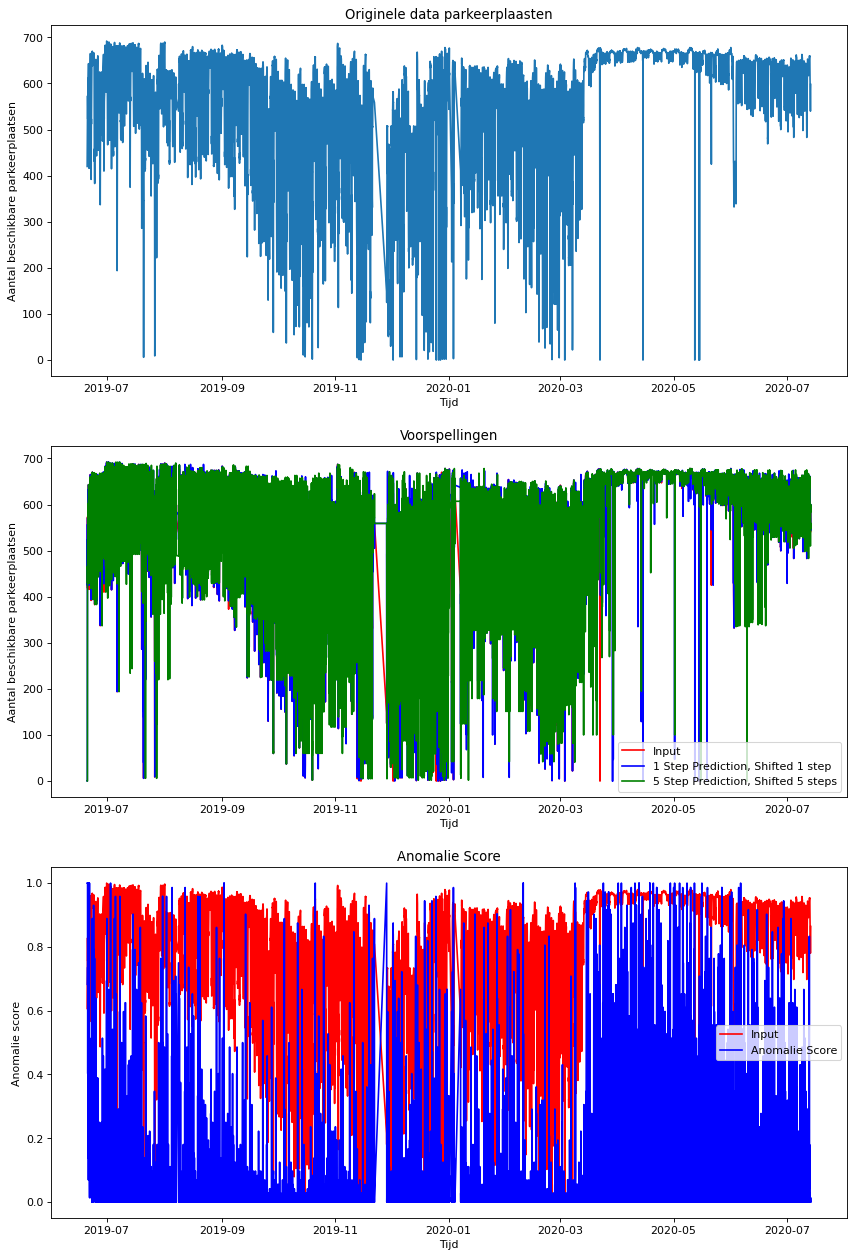

In [4]:
inputs = htm_output[0]
predictions = htm_output[1]
anomalies = htm_output[2]
execution_time = htm_output[3]

print(f'HTM executed in: {execution_time} seconds')

timestamps = pd.read_csv("p10.csv")['Timestamp']
timestamps = pd.to_datetime(timestamps)
timestamps = timestamps.to_numpy()


plt.figure(figsize=(13, 20), dpi= 79, facecolor='w', edgecolor='k')

plt.subplot(3,1,1)
plt.title("Originele data parkeerplaasten")
plt.xlabel("Tijd")
plt.ylabel("Aantal beschikbare parkeerplaatsen")
plt.plot(timestamps, inputs)

plt.subplot(3,1,2)
plt.title("Voorspellingen")
plt.xlabel("Tijd")
plt.ylabel("Aantal beschikbare parkeerplaatsen")
plt.plot(timestamps, inputs, 'red',
         timestamps, predictions[1], 'blue',
         timestamps, predictions[5], 'green',)
plt.legend(labels=('Input', '1 Step Prediction, Shifted 1 step', '5 Step Prediction, Shifted 5 steps'))

plt.subplot(3,1,3)
plt.title("Anomalie Score")
plt.xlabel("Tijd")
plt.ylabel("Anomalie score")
inputs = np.array(inputs) / max(inputs)
plt.plot(timestamps, inputs, 'red',
         timestamps, anomalies, 'blue',)
plt.legend(labels=('Input', 'Anomalie Score'))

plt.show()

In [5]:
parking_data = pd.read_csv("./p10.csv")
parking_data_anomalies = parking_data.copy(deep=True)
parking_data_anomalies['likelihood'] = anomalies

In [6]:
# Verwijder eerste 15% van de data - anomalieën hier zijn incorrect wegens te weinig data
n_rows = math.floor(len(parking_data_anomalies) * 0.85)
parking_data_anomalies = parking_data_anomalies.tail(n_rows)

In [7]:
# anomalie als likelihood boven 90% ligt
parking_data_anomalies = parking_data_anomalies[parking_data_anomalies['likelihood'] > 0.90]

In [8]:
print(f'{len(parking_data_anomalies)} anomalies detected')
print('')
print(parking_data_anomalies)

63 anomalies detected

                 Timestamp  Available  likelihood
5595   2019-08-19 03:40:00        672    0.958333
5698   2019-08-20 05:24:00        667    0.958333
6943   2019-09-02 04:29:00        670    1.000000
8054   2019-09-13 18:27:00        595    0.902778
11620  2019-10-21 05:48:00        655    1.000000
...                    ...        ...         ...
33125  2020-06-06 01:56:00        650    1.000000
33523  2020-06-10 05:39:00        653    0.916667
33987  2020-06-15 01:17:00        653    0.916667
34466  2020-06-20 01:40:00        650    0.902778
35347  2020-06-29 05:30:00        650    0.944444

[63 rows x 3 columns]


### Plotten van de data met aanduiding van de gedetecteerde anomalieën

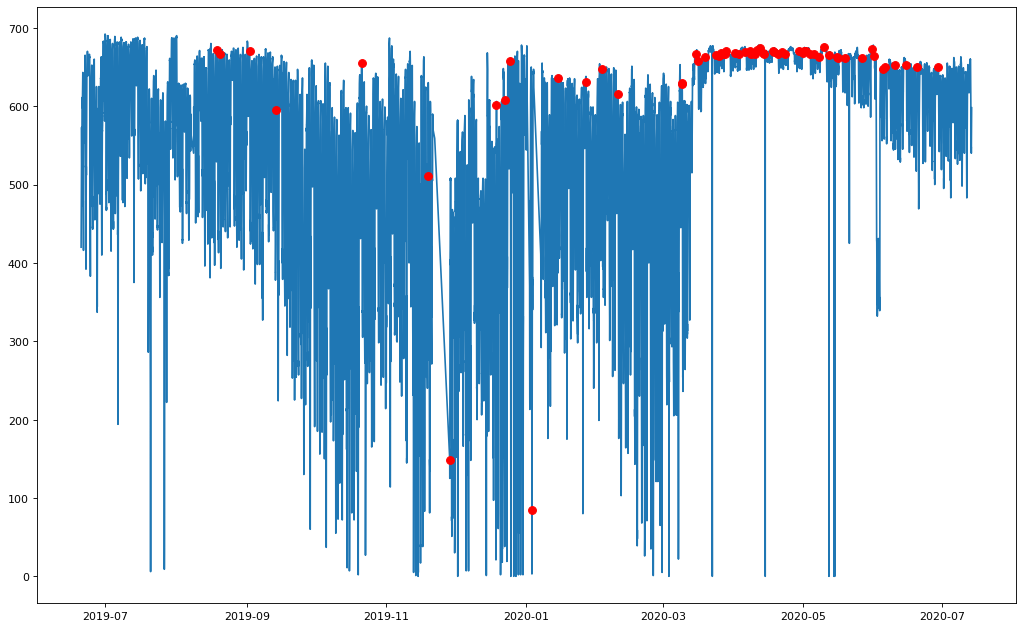

In [9]:
# Plotten van anomalieën op grafiek
parking_timestamp_index = parking_data.copy(deep=True)
parking_timestamp_index['Timestamp'] = pd.to_datetime(parking_timestamp_index['Timestamp'])
parking_timestamp_index = parking_timestamp_index.set_index('Timestamp')

parking_data_anomalies['Timestamp'] = pd.to_datetime(parking_data_anomalies['Timestamp'])

plt.figure(figsize=(16, 10), dpi= 79, facecolor='w', edgecolor='k')
plt.plot(parking_timestamp_index.index, parking_timestamp_index['Available'], zorder=1)
plt.scatter(parking_data_anomalies['Timestamp'], parking_data_anomalies['Available'], c='Red', s=50, zorder=2)
plt.show()

In [10]:
# Unieke dagen filteren waar anomalieën zich voordoen
unique_dates = pd.to_datetime(parking_data_anomalies['Timestamp'])
unique_dates = unique_dates.map(pd.Timestamp.date).unique()
print(unique_dates)

[datetime.date(2019, 8, 19) datetime.date(2019, 8, 20)
 datetime.date(2019, 9, 2) datetime.date(2019, 9, 13)
 datetime.date(2019, 10, 21) datetime.date(2019, 11, 19)
 datetime.date(2019, 11, 28) datetime.date(2019, 12, 19)
 datetime.date(2019, 12, 23) datetime.date(2019, 12, 25)
 datetime.date(2020, 1, 3) datetime.date(2020, 1, 15)
 datetime.date(2020, 1, 27) datetime.date(2020, 2, 3)
 datetime.date(2020, 2, 10) datetime.date(2020, 3, 9)
 datetime.date(2020, 3, 15) datetime.date(2020, 3, 16)
 datetime.date(2020, 3, 19) datetime.date(2020, 3, 24)
 datetime.date(2020, 3, 25) datetime.date(2020, 3, 26)
 datetime.date(2020, 3, 27) datetime.date(2020, 3, 28)
 datetime.date(2020, 4, 1) datetime.date(2020, 4, 2)
 datetime.date(2020, 4, 5) datetime.date(2020, 4, 7)
 datetime.date(2020, 4, 8) datetime.date(2020, 4, 10)
 datetime.date(2020, 4, 11) datetime.date(2020, 4, 12)
 datetime.date(2020, 4, 13) datetime.date(2020, 4, 14)
 datetime.date(2020, 4, 17) datetime.date(2020, 4, 18)
 datetime.dat